### Exploring Customer Segmentation


<center>
    <img src = images/segments.jpeg>
</center>


In this activity, you are tasked with profiling customer groups for a large telecommunications company.  The data provided contains information on customers purchasing and useage behavior with the telecom products.  Your goal is to use PCA and clustering to segment these customers into meaningful groups, and report back your findings.  

Because these results need to be interpretable, it is important to keep the number of clusters reasonable.  Think about how you might represent some of the non-numeric features so that they can be included in your segmentation models.  You are to report back your approach and findings to the class.  Be specific about what features were used and how you interpret the resulting clusters.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

/tmp/ipykernel_45224/1213336903.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
df = pd.read_csv('data/telco_churn_data.csv')
df = df.set_index('Customer ID')

In [46]:
df.head()

,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,...,Latitude,Longitude,Population,Churn Value,CLTV,Churn Category,Churn Reason,Total Customer Svc Requests,Product/Service Issues Reported,Customer Satisfaction
Customer ID,,,,,,,,,,,,,,,,,,,,,
8779-QRDMV,No,0,1,NaN,No,0.00,No,Yes,Fiber Optic,9,...,34.023810,-118.156582,68701,1,5433,Competitor,Competitor offered more data,5,0,NaN
7495-OOKFY,Yes,1,8,Offer E,Yes,48.85,Yes,Yes,Cable,19,...,34.044271,-118.185237,55668,1,5302,Competitor,Competitor made better offer,5,0,NaN
1658-BYGOY,No,0,18,Offer D,Yes,11.33,Yes,Yes,Fiber Optic,57,...,34.108833,-118.229715,47534,1,3179,Competitor,Competitor made better offer,1,0,NaN
4598-XLKNJ,Yes,1,25,Offer C,Yes,19.76,No,Yes,Fiber Optic,13,...,33.936291,-118.332639,27778,1,5337,Dissatisfaction,Limited range of services,1,1,2.0
4846-WHAFZ,Yes,1,37,Offer C,Yes,6.33,Yes,Yes,Cable,15,...,33.972119,-118.020188,26265,1,2793,Price,Extra data charges,1,0,2.0


In [26]:
df_clean = df.drop(['Total Refunds', 'Total Long Distance Charges', 'Zip Code', 'Latitude', 'Longitude','Population'], axis = 1)
df_clean = df_clean.dropna(axis = 1)

# df_clean = df_clean.replace('Yes', 1)
# df_clean = df_clean.replace('No', 0)

df_clean = df_clean.replace('Month-to-Month', 1)
df_clean = df_clean.replace('One Year', 12)
df_clean = df_clean.replace('Two Year', 24)

# df_clean = df_clean.replace('Male', 0)
# df_clean = df_clean.replace('Female', 1)

object_cols = df_clean.select_dtypes('object').columns.tolist()
df_clean = df_clean.drop(object_cols, axis=1)

df_clean.sample(10)

/tmp/ipykernel_45224/939667435.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean = df_clean.replace('Two Year', 24)


,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Contract,Monthly Charge,Total Regular Charges,Total Extra Data Charges,Age,Number of Dependents,Churn Value,CLTV,Total Customer Svc Requests,Product/Service Issues Reported
Customer ID,,,,,,,,,,,,,,
1564-HJUVY,0,4,3.03,11,1,63.750,226.20,25.0,53,0,0,2624,0,0
0795-LAFGP,1,71,3.57,52,24,90.400,6668.05,0.0,25,0,0,5633,0,0
0506-LVNGN,0,5,42.33,10,1,78.572,349.65,35.0,78,0,1,4028,5,4
6743-HHQPF,5,42,0.00,59,1,25.100,1097.15,647.0,26,0,0,4959,2,0
6646-VRFOL,1,53,39.36,25,1,108.004,5485.50,1371.0,74,0,1,5860,2,1
7765-LWVVH,8,72,18.74,19,24,95.100,6843.15,0.0,39,2,0,5584,1,0
9924-JPRMC,0,72,36.49,27,24,118.200,8547.15,2308.0,60,0,0,4886,0,0
4320-QMLLA,0,7,5.61,24,1,54.850,370.40,89.0,57,0,0,3481,0,0
9993-LHIEB,5,67,2.12,58,24,67.850,4627.65,0.0,21,0,0,4792,1,0


In [27]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_clean)

df_scaled = pd.DataFrame(data_scaled, columns = df_clean.columns)
df_scaled

,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Contract,Monthly Charge,Total Regular Charges,Total Extra Data Charges,Age,Number of Dependents,Churn Value,CLTV,Total Customer Svc Requests,Product/Service Issues Reported
0,-0.650409,-1.278988,-1.486303,-0.578169,-0.881056,-0.794089,-0.988823,-0.406574,1.880110,-0.486835,1.663829,0.872974,2.559635,-0.42944
1,-0.317185,-0.993743,1.676120,-0.100773,-0.881056,0.599164,-0.726848,-0.231389,1.641292,0.551874,1.663829,0.762236,2.559635,-0.42944
2,-0.650409,-0.586250,-0.752828,1.713331,-0.881056,1.102095,-0.232929,-0.406574,1.462179,2.629292,1.663829,-1.032395,-0.236845,-0.42944
3,-0.317185,-0.301005,-0.207092,-0.387210,-0.881056,1.205739,0.103315,0.070805,1.880110,0.551874,1.663829,0.791822,-0.236845,0.96436
4,-0.317185,0.187986,-1.076516,-0.291731,-0.881056,0.458140,0.259379,0.221172,1.999519,0.551874,1.663829,-1.358692,-0.236845,-0.42944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,-0.650409,1.614210,-0.012232,-1.007825,1.483486,-1.450395,-0.379946,-0.406574,-0.985705,-0.486835,-0.601023,0.765617,-0.935965,-0.42944
7039,-0.317185,-0.341755,0.847481,0.137925,0.249812,0.629356,-0.127923,-0.406574,-0.508069,1.590583,-0.601023,-1.910691,0.462275,-0.42944
7040,0.682487,1.614210,0.433808,1.808810,0.249812,1.230572,2.242888,5.935116,-0.985705,1.590583,-0.601023,0.980330,0.462275,-0.42944
7041,-0.317185,-0.871495,-1.486303,-0.196252,-0.881056,-1.174293,-0.853434,-0.406574,-0.866296,1.590583,-0.601023,-1.358692,-0.935965,-0.42944


In [28]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Number of Referrals                7043 non-null   float64
 1   Tenure in Months                   7043 non-null   float64
 2   Avg Monthly Long Distance Charges  7043 non-null   float64
 3   Avg Monthly GB Download            7043 non-null   float64
 4   Contract                           7043 non-null   float64
 5   Monthly Charge                     7043 non-null   float64
 6   Total Regular Charges              7043 non-null   float64
 7   Total Extra Data Charges           7043 non-null   float64
 8   Age                                7043 non-null   float64
 9   Number of Dependents               7043 non-null   float64
 10  Churn Value                        7043 non-null   float64
 11  CLTV                               7043 non-null   float

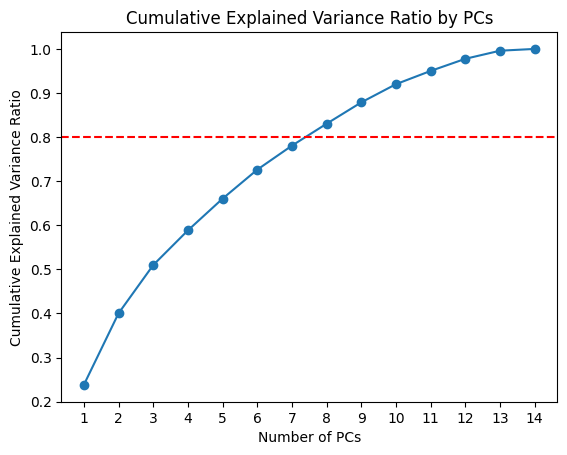

In [29]:
pca_test = PCA(n_components=len(df_scaled.columns))
pca_test.fit_transform(df_scaled)

explained_variance_ratio = pca_test.explained_variance_ratio_
total_explained_variance_ratio = explained_variance_ratio.sum()

cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(df_scaled.columns)+1), cumulative_variance_ratio, marker='o')
plt.xticks(range(1, len(df_scaled.columns)+1))
plt.axhline(y=0.8, c='r', ls='--')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by PCs')
plt.show()


In [30]:
pca = PCA(n_components=7)
X_pca = pca.fit_transform(df_scaled)

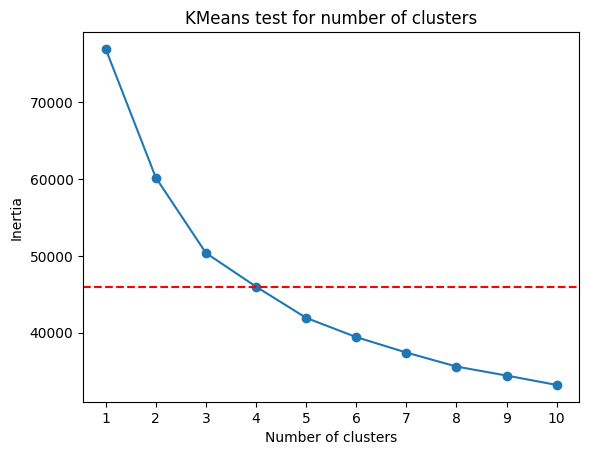

In [43]:
inertia_list = []

for i in range(1, 11):
    kmeans_test = KMeans(n_clusters=i).fit(X_pca)
    inertia_list.append(kmeans_test.inertia_)

plt.plot(range(1, 11), inertia_list, marker = 'o')
plt.xticks(range(1, 11))
plt.title('KMeans test for number of clusters')
plt.ylabel('Inertia')
plt.xlabel('Number of clusters')
plt.axhline(inertia_list[3], c='r', ls='--')
plt.show()

In [38]:
kmeans_pca = KMeans(n_clusters=4)
kmeans_pca.fit(X_pca)

# The cluster labels for each data point
cluster_labels = kmeans_pca.labels_

In [39]:
# Get the PCA components (loadings)
pca_components = pca.components_

# Create a DataFrame for better visualization and analysis
pca_loadings_df = pd.DataFrame(pca_components, columns=df_clean.columns, index=[f'PC{i+1}' for i in range(pca.n_components)])

# Display the loadings
pca_loadings_df

,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Contract,Monthly Charge,Total Regular Charges,Total Extra Data Charges,Age,Number of Dependents,Churn Value,CLTV,Total Customer Svc Requests,Product/Service Issues Reported
PC1,0.263465,0.480811,0.028119,0.093264,0.383584,0.164651,0.452040,0.243523,-0.035185,0.136142,-0.302023,0.252549,-0.215801,-0.175173
PC2,-0.116449,0.051995,0.077881,0.361079,-0.174336,0.505208,0.277421,0.327305,0.004572,-0.150993,0.400781,0.047086,0.334259,0.283166
PC3,0.079749,-0.168879,-0.071991,0.529135,-0.159316,-0.112692,-0.160243,0.239083,-0.619045,0.345412,-0.116497,-0.148088,-0.104753,-0.100164
PC4,0.412358,0.081268,-0.233706,-0.089687,0.154521,-0.221166,-0.074238,-0.039654,0.049553,0.497271,0.169082,0.162248,0.408359,0.457619
PC5,0.242337,-0.085630,0.906240,-0.072509,-0.067026,0.090763,-0.030234,-0.080838,0.034479,0.270635,-0.011469,-0.103842,0.043171,0.004745
PC6,0.336375,-0.103481,-0.277422,0.072196,-0.132648,0.294386,0.073487,0.026242,0.463392,0.227819,-0.023099,-0.608982,-0.122906,-0.174609
PC7,-0.011029,0.169794,0.089286,-0.104627,0.388202,-0.154572,0.046899,0.142954,-0.243584,-0.300357,-0.075883,-0.653063,0.017642,0.415684


In [40]:
# Inverse transform the cluster centers
original_space_centroids = scaler.inverse_transform(pca.inverse_transform(kmeans_pca.cluster_centers_))

# Create a DataFrame for the inverse transformed cluster centers
centroids_df = pd.DataFrame(original_space_centroids, columns=df_clean.columns)

# Display the centroids
centroids_df

,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Contract,Monthly Charge,Total Regular Charges,Total Extra Data Charges,Age,Number of Dependents,Churn Value,CLTV,Total Customer Svc Requests,Product/Service Issues Reported
0,0.399659,13.796382,23.283035,23.893037,0.865538,77.844248,1303.461385,223.993597,52.089630,0.115745,0.875842,4120.335917,3.109516,1.092490
1,0.849639,16.880896,22.278545,20.959861,5.052402,55.479770,898.726772,64.603035,43.435774,0.314976,0.202962,3852.116248,0.827127,-0.003659
2,3.246805,60.350035,25.012617,30.133860,16.591416,91.080526,5185.481759,810.809673,47.132271,0.527349,0.100460,5113.480240,0.942315,0.133949
3,3.740548,40.316101,20.904879,5.662040,17.039792,33.773815,1666.468159,-37.846244,44.922152,1.038025,-0.058044,4657.457200,0.861765,0.243099
